### Fraud Detection in Enron Company Using Machine Learning

It has been observed that most frauds that happen in organization can be detected by peep down into the insight of financial data and communication data. I have used the Enron email and finance data and email communication to study and investigate the fraud detection by applying different data analysis and machine learning techniques and eventually calculated the optimize performance of algorithm. Since we know, Enron Corporation was one of the company in America based on energy, commodities and services. Even in 2000, Enron was known as largest companies in the natural gas. By 2002, it had collapsed into bankruptcy due to the widespread one of the biggest infamous corporate scandal executed by company’s employees who were at the senior most positions. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives.


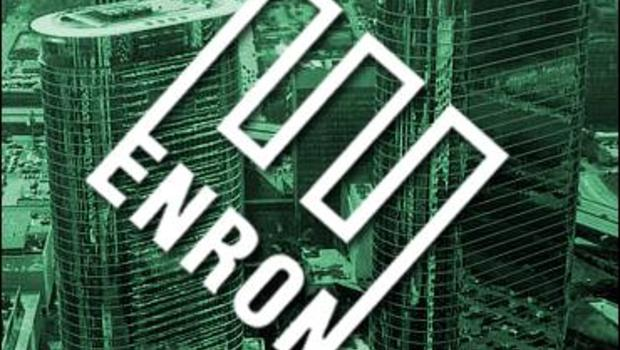

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Problem Definition

from IPython.display import Image
Image("enron.jpg")

### Load neccesary libraries

In [2]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")
sys.path.append("../test/")
sys.path.append("../datasets/")
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from pprint import pprint
%matplotlib inline
import numpy as np

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load data from the dictionary

In [3]:
### Load the dictionary containing the dataset
data_dict = pickle.load(open("/Users/seemamishra/Desktop/Udacity/Intro to machine learning/ud120-projects/final_project/Enron Fraud Detection/datasets/final_project_dataset.pkl", "r"))

# Part One - Understanding the Dataset and Question

## Data Exploration
Its recommended to explore and prepare data before uisng to build in machine learning in order to ensure the good performance of predictive model.


In [4]:
# number of data points
"the number of data points", len(data_dict.keys())

('the number of data points', 146)

In [5]:
# number of features available
"the number of features",len(data_dict['METTS MARK'])

('the number of features', 21)

In [6]:
# available features
data_dict["METTS MARK"].keys()

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [7]:
# people of interest
count = 0
for key, item in data_dict.iteritems():
    if item["poi"]:
        print key
        count += 1
count

HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F


18

#### Number od instances fro each class

18 128


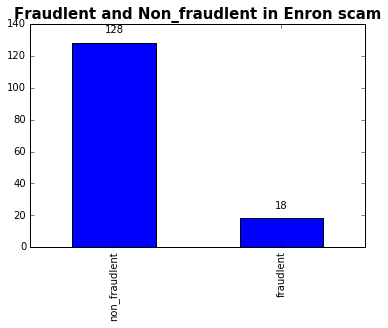

In [8]:
poi = 0
non_poi = 0
for key, item in data_dict.iteritems():
    if item["poi"] == True:
        poi += 1
    else:
        non_poi += 1

print poi, non_poi

d = {'poi' : poi, 'non_poi' : non_poi}
d=pd.Series(d)
x_labels = ['non_fraudlent','fraudlent']
ax = d.plot(kind = 'bar' )
plt.title("Fraudlent and Non_fraudlent in Enron scam", fontsize = 15, fontweight = 'bold')
# plt.figure(figsize=(20,10))
ax.set_xticklabels(x_labels)
rects = ax.patches
# Now make some labels
labels = [128, 18]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

# 7:1 -> highly unbalanced classification problem

In [9]:
# create a dictionary for all missing values
missing_features = {}
for key, item in data_dict.iteritems():
    for elem, value in item.iteritems():
        if value == "NaN":
            if elem not in missing_features:
                missing_features[elem] = 1
            else:
                missing_features[elem] += 1
print "features with missing values"
missing_features

features with missing values


{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}

#### Data exploration result

* There are 146 data points with 21 features.
* Lets us look at the type of  feaures available in data:

  **email_features**
    * Number of emails sent: from_messages
    * Number of emails received: to_messages
    * Number of emails sent to POIs: from_this_person_to_poi
    * Number of emails received from POIs: from_poi_to_this_person
    
  **finance_features**
    * bonus 
    * salary 
    * exercised_stock_options 
    * share value features
    * etc.
* There are 18 people who is an person of interest(involved in fraud and 128 are not involved in fraud .
* 1,358 data points are missing.
* The top 3 features which have more than 100 missing values "deferral_payments", "loan_advances", "director_fees", and "restricted_stock_deferred". 
* More detailed exploration and analysis are listed as below.


Its not the good idea to drop all entries with NAN, might be the case, it will loss information to find the fraudlent involved in case. So, let us explore more data and analyze. 

# Part Two - Outlier Investigation


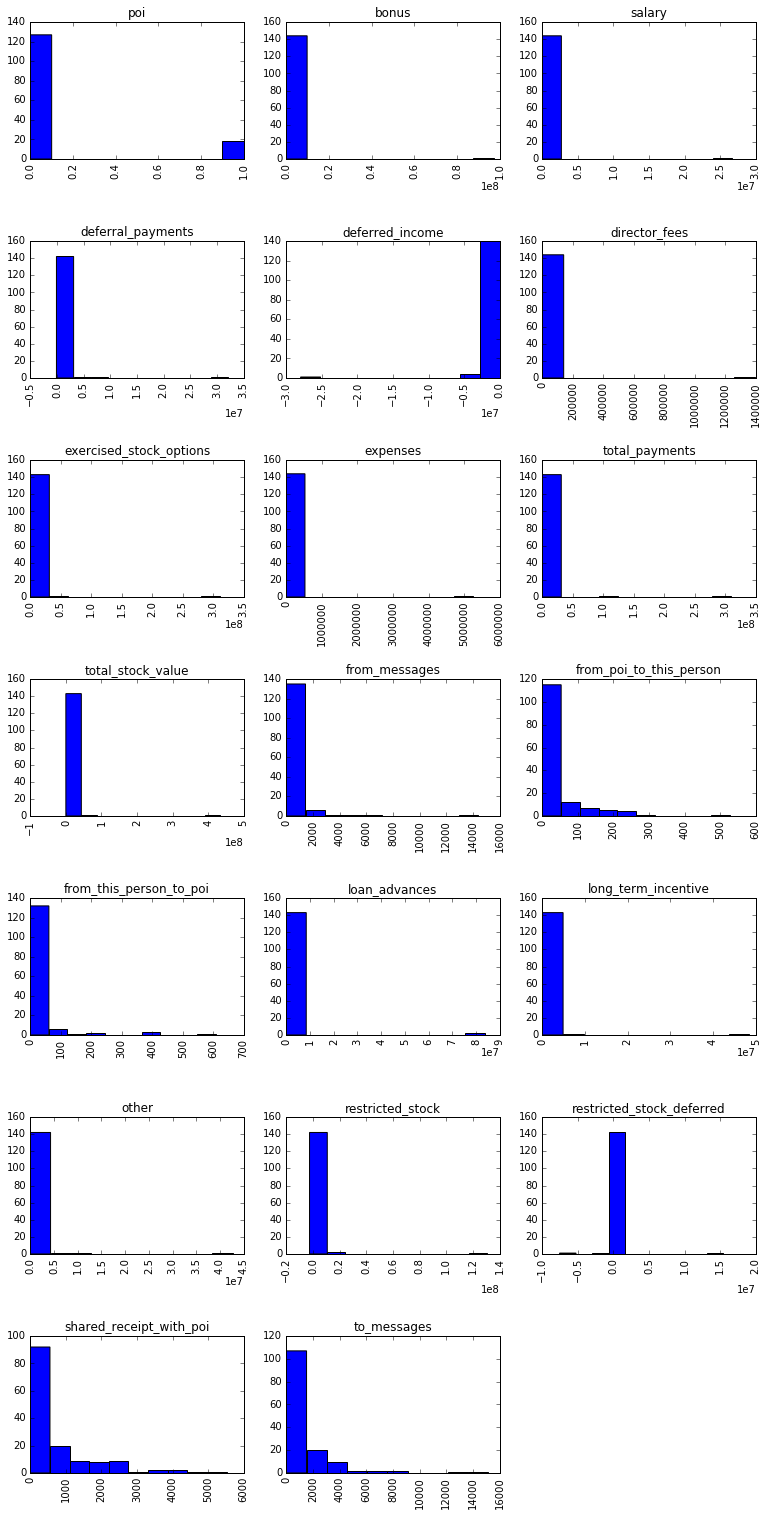

In [10]:
# Preparing all features and data to test the outlier.
# hide_me
features_list = [   'poi',
                    'bonus',
                    'salary',
                    'deferral_payments',
                    'deferred_income',
                    'director_fees',
                    'exercised_stock_options',
                    'expenses',
                    'total_payments',
                    'total_stock_value',
                    'from_messages',
                    'from_poi_to_this_person',
                    'from_this_person_to_poi',
                    'loan_advances',
                    'long_term_incentive',
                    'other',
                    'restricted_stock',
                    'restricted_stock_deferred',
                    'shared_receipt_with_poi',
                    'to_messages'
                   ]
data_to_test = featureFormat(data_dict, features_list)

fig = plt.figure(figsize=(13, 26))

for idx, feature in enumerate(features_list):
    # This means: Divide that canvas to 7 rows, 3 columns,
    # and at idx+1 position (since subplot is base-1), draw our plot.
    ax = plt.subplot(7,3, idx+1)
    
    plt.title(feature)
    plt.xticks(rotation='vertical')
    
    # hspace here sets space between rows.
    # http://matplotlib.org/api/figure_api.html#matplotlib.figure.SubplotParams
    plt.subplots_adjust(hspace=.6) 
    
    ax.hist(data_to_test[:,idx])

Observing above figure, it shows there are certain features which seems to have outliers and distorts the distribution of data which needed to fix.

* salary
* bonus
* deferral_payments
* deferred_income
* loan_advances
* long_term_incentive
* other
* restricted_stock
* restricted_stock_deferred
* exercised_stock_options'

It exhibited that largest scale in x axis is 1e7(i.e. 10000000) for some features in the chart, even one chart(total_payment) has scale 1e8(100000000).   
The purpose of removing oultiers to prevent the predictive model learn from the extreme value(small or large) and produce misleading results.
To find out the outliers in the data set which is mostly finacial data, lets look into deep insight.

In [12]:
def show_largest_five(data_dict, features, feature):
    # What are the 5 largest points, sorted by x?
    print "5 largest", feature
    sorted_list = sorted(data_dict.iteritems(), 
                 key=lambda (key, val): int(0 if val[feature] == 'NaN' else val[feature]), reverse=True)[0:5]
    print [(i[0]+ "(" + ('poi' if i[1]['poi'] else 'not poi') + "): "+ str(i[1][feature])) for i in sorted_list]

In [13]:
show_largest_five(data_dict, features_list, 'salary')

5 largest salary
['TOTAL(not poi): 26704229', 'SKILLING JEFFREY K(poi): 1111258', 'LAY KENNETH L(poi): 1072321', 'FREVERT MARK A(not poi): 1060932', 'PICKERING MARK R(not poi): 655037']


TOTAL which has no information is ceratainly the oultier in 'bonus' and 'salary' featurews which to remove to fix the oultier. TOTAL is also not belongs to poi and it is assumed who has involved in the scam surely was getting the higher income.

## Remove the TOTAL Data Point
As we already known in mini projects, there is an outlier named "TOTAL" in this dataset. We will need to remove it before any further analysis.

In [14]:
if 'TOTAL' in data_dict:
    del data_dict['TOTAL']

In order to see the financial data belongs to each employee, lets us see the top five person's data and to check whether they are POI on not.

In [15]:
# hide_me
show_largest_five(data_dict, features_list, 'bonus')
print("\n")
show_largest_five(data_dict, features_list, 'exercised_stock_options')
print("\n")
show_largest_five(data_dict, features_list, 'loan_advances')
print("\n")
show_largest_five(data_dict, features_list, 'other')
print("\n")
show_largest_five(data_dict, features_list, 'restricted_stock')
print("\n")
show_largest_five(data_dict, features_list, 'restricted_stock_deferred')


5 largest bonus
['LAVORATO JOHN J(not poi): 8000000', 'LAY KENNETH L(poi): 7000000', 'SKILLING JEFFREY K(poi): 5600000', 'BELDEN TIMOTHY N(poi): 5249999', 'ALLEN PHILLIP K(not poi): 4175000']


5 largest exercised_stock_options
['LAY KENNETH L(poi): 34348384', 'HIRKO JOSEPH(poi): 30766064', 'RICE KENNETH D(poi): 19794175', 'SKILLING JEFFREY K(poi): 19250000', 'PAI LOU L(not poi): 15364167']


5 largest loan_advances
['LAY KENNETH L(poi): 81525000', 'FREVERT MARK A(not poi): 2000000', 'PICKERING MARK R(not poi): 400000', 'METTS MARK(not poi): NaN', 'BAXTER JOHN C(not poi): NaN']


5 largest other
['LAY KENNETH L(poi): 10359729', 'FREVERT MARK A(not poi): 7427621', 'MARTIN AMANDA K(not poi): 2818454', 'BAXTER JOHN C(not poi): 2660303', 'SHERRIFF JOHN R(not poi): 1852186']


5 largest restricted_stock
['LAY KENNETH L(poi): 14761694', 'WHITE JR THOMAS E(not poi): 13847074', 'PAI LOU L(not poi): 8453763', 'SKILLING JEFFREY K(poi): 6843672', 'FREVERT MARK A(not poi): 4188667']


5 largest re

From the above, I concluded the following  
* Except for restricted_stock_deferred, the vlaues seem normal enough to use in our classifiers, as we can see that the largest values belongs to a POI.
* restricted_stock_deferred could be an outlier, but I am not sure at the moment, since it is possible, though perhaps unlikely, that may be the BHATNAGAR SANJAY does have that much difference of amount as compared to others.  

One way to find this out for sure is by comparing our dataset with the raw data which I do in the next section.

#### Check out the raw(enron61702insiderpay.pdf) data for outliers
Find how the features correlate
From the pdf, we can find that there are two groups of insider pays:
total_payments, which is a combination of:
* salary
* bonus
* director_fees
* deferral_payments
* deferred_income
* loan_advances
* long_term_incentive
* expenses
* other
* salary
* total_stock_value, a combination of:
* restricted_stock
* exercised_stock_options
* restricted_stock_deferred

By having this knowledge, we know that we can confirm if the features' values are correct by running a small script that calculates total_payments and total_stock_value from other features, and report to us data points where the calculations were off.
First we do it for total_payments, here is the report:

In [16]:
# hide_me
#function to convert dictionaty to panda frames
def to_pandas(dict):
    df = pd.DataFrame.from_dict(dict, orient='index')
    df.reset_index(level=0, inplace=True)
    columns = list(df.columns)
    columns[0] = 'name'
    df.columns = columns
    return(df)
Enron_data = to_pandas(data_dict)
Enron_data.replace('NaN', np.nan, inplace = True)
df1 =pd.DataFrame()
df = Enron_data
df = df.fillna(0)

df1 = df1.fillna(0)
df1['name'] = df['name']
df1['combined'] = (df['bonus'] + 
                   df['director_fees'] 
                   +df['deferral_payments']
                   +df['deferred_income'] 
                   +df['loan_advances'] 
                   +df['long_term_incentive'] 
                   +df['expenses'] +df['other'] +df['salary'])
df1['total_payments'] = df['total_payments']
df1['equals?'] = (df1['combined'] == df1['total_payments'])
df1['poi'] = df['poi']
print df1.head(5)
print np.sum(df1['equals?']), " out of ", len(df1)
print "Total difference between combined and total_payments: ", (np.sum(df1['total_payments']) - np.sum(df1['combined']))
print "\n"
print "Which data points are different?"
print df1[df1['equals?'] == False]

                 name   combined  total_payments equals?    poi
0     ALLEN PHILLIP K  4484442.0       4484442.0    True  False
1       BADUM JAMES P   182466.0        182466.0    True  False
2  BANNANTINE JAMES M   916197.0        916197.0    True  False
3       BAXTER JOHN C  5634343.0       5634343.0    True  False
4      BAY FRANKLIN R   827696.0        827696.0    True  False
143  out of  145
Total difference between combined and total_payments:  15382277.0


Which data points are different?
                name  combined  total_payments equals?    poi
8      BELFER ROBERT  -99215.0        102500.0   False  False
11  BHATNAGAR SANJAY  275728.0      15456290.0   False  False


We got to see that two persons BELFER ROBERT,BHATNAGAR SANJAY  have diiferecne in amount and they are not poi.

In [17]:
# for stock exchange
# hide_me
# dataframe to check total_stock_value
df2 = pd.DataFrame()
df = Enron_data
df = df.fillna(0)

df2['combined'] = (
    df['restricted_stock'] +
    df['exercised_stock_options'] +
    df['restricted_stock_deferred']
)
df2['total_stock_value'] = df['total_stock_value']
df2['equals?'] = (df2['combined'] == df2['total_stock_value'])
df2['poi'] = df['poi']
print df2.head(5)
print np.sum(df2['equals?']), " out of ", len(df2)
print "Total difference between combined and total_stock_value: ", (np.sum(df2['total_stock_value']) - np.sum(df2['combined']))
print "\n"
print "Which data points are different?"
print df2[df2['equals?'] == False]
# df.isin(df2[df2['equals?'] == False]['name'].tolist())]

     combined  total_stock_value equals?    poi
0   1729541.0          1729541.0    True  False
1    257817.0           257817.0    True  False
2   5243487.0          5243487.0    True  False
3  10623258.0         10623258.0    True  False
4     63014.0            63014.0    True  False
143  out of  145
Total difference between combined and total_stock_value:  -15547761.0


Which data points are different?
      combined  total_stock_value equals?    poi
8      47378.0           -44093.0   False  False
11  15456290.0                0.0   False  False


We have seen two outliers which are both same for total_stock_value and total_payments. Now lets us comapre these valus with information available(assuming this is correct) into enron61702insiderpay.pdf file and fix them manually.

In [18]:
# hide_me
data_dict_updated = data_dict
data_dict_updated['BELFER ROBERT']['deferred_income'] = -102500
data_dict_updated['BELFER ROBERT']['deferral_payments'] = 'NaN'
data_dict_updated['BELFER ROBERT']['expenses'] = 3285
data_dict_updated['BELFER ROBERT']['director_fees'] = 102500
data_dict_updated['BELFER ROBERT']['total_payments'] = 3285
data_dict_updated['BELFER ROBERT']['exercised_stock_options'] = 'NaN'
data_dict_updated['BELFER ROBERT']['restricted_stock'] = 44093
data_dict_updated['BELFER ROBERT']['restricted_stock_deferred'] = -44093
data_dict_updated['BELFER ROBERT']['total_stock_value'] = 'NaN'

data_dict_updated['BHATNAGAR SANJAY']['other'] = 'NaN'
data_dict_updated['BHATNAGAR SANJAY']['expenses'] = 137864
data_dict_updated['BHATNAGAR SANJAY']['director_fees'] = 'NaN'
data_dict_updated['BHATNAGAR SANJAY']['total_payments'] = 137864
data_dict_updated['BHATNAGAR SANJAY']['exercised_stock_options'] = 15456290
data_dict_updated['BHATNAGAR SANJAY']['restricted_stock'] = 2604490
data_dict_updated['BHATNAGAR SANJAY']['restricted_stock_deferred'] = -2604490
data_dict_updated['BHATNAGAR SANJAY']['total_stock_value'] = 15456290



#### Now plot graph to the distribution 

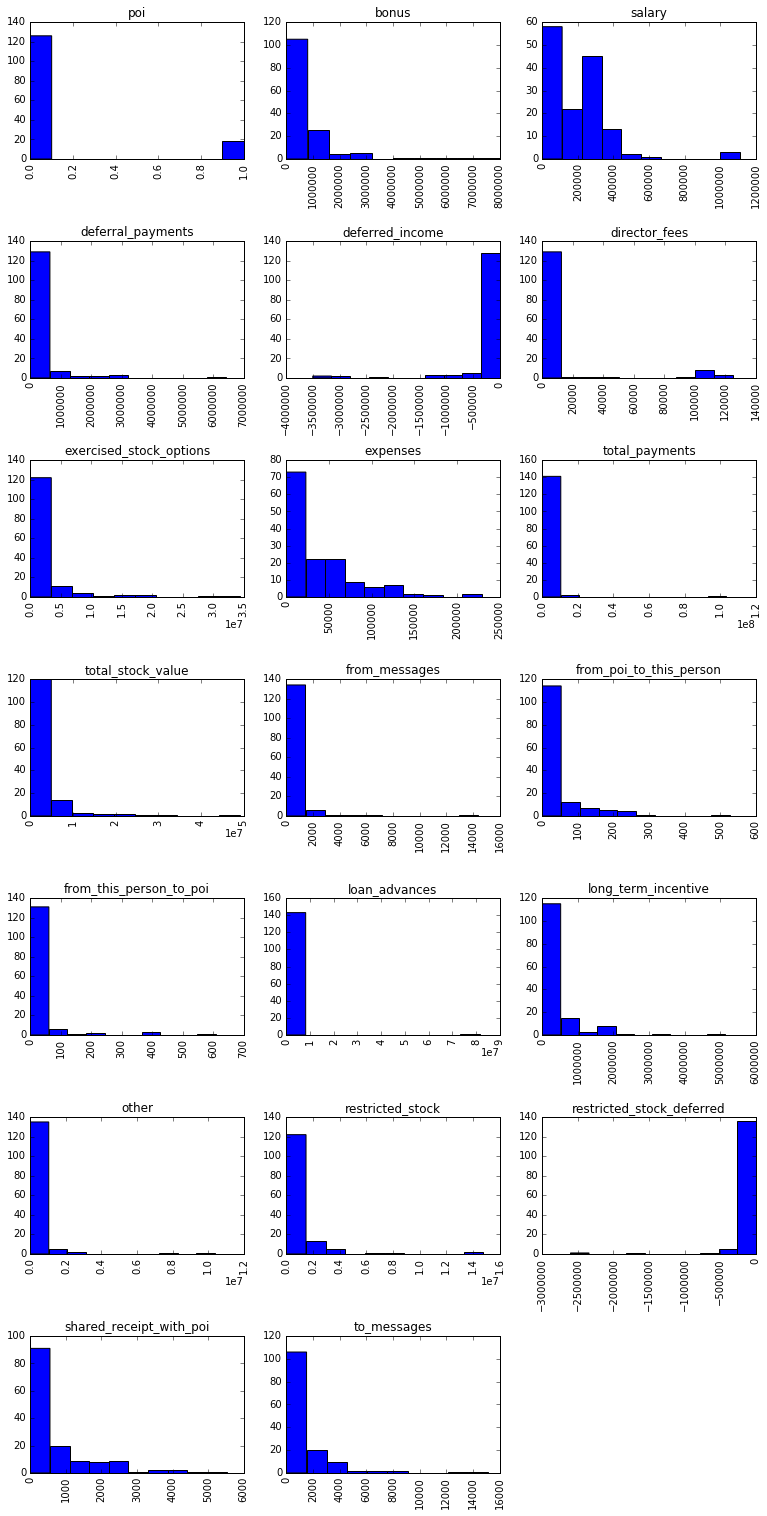

In [19]:
features_list = [  'poi',
                    'bonus',
                    'salary',
                    'deferral_payments',
                    'deferred_income',
                    'director_fees',
                    'exercised_stock_options',
                    'expenses',
                    'total_payments',
                    'total_stock_value',
                    'from_messages',
                    'from_poi_to_this_person',
                    'from_this_person_to_poi',
                    'loan_advances',
                    'long_term_incentive',
                    'other',
                    'restricted_stock',
                    'restricted_stock_deferred',
                    'shared_receipt_with_poi',
                    'to_messages'
                   ]
data_to_test = featureFormat(data_dict_updated, features_list)

fig = plt.figure(figsize=(13, 26))

for idx, feature in enumerate(features_list):
    # This means: Divide that canvas to 6 rows, 3 columns,
    # and at idx+1 position (since subplot is base-1), draw our plot.
    ax = plt.subplot(7,3, idx+1)
    
    plt.title(feature)
    plt.xticks(rotation='vertical')
    
    # hspace here sets space between rows.
    # http://matplotlib.org/api/figure_api.html#matplotlib.figure.SubplotParams
    plt.subplots_adjust(hspace=.6) 
    
    ax.hist(data_to_test[:,idx])

## Remove Outliers

Instead of removing a certain percent of data points by each features directly, as a starting point, we will fit a dummy linear regression model, calculate the deviations, and treat data points with the highest deviations as outliers.

In [20]:
### Convert all NaN values to 0.
# hide_me

for name, item in data_dict_updated.items():
    for key in features_list:
        if item[key] == 'NaN':
            data_dict_updated[name][key] = 0

First of all, prepare features and labels.

In [21]:
### Store to my_dataset for easy export below.
my_dataset = data_dict_updated

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

Since we only want to remove the outliers by getting deviations from a linear model, there's no need to split the dataset as for now. The model is built as following,

In [22]:
def buildRegression(features, labels):
    """
        Build a linear regression model for outliers cleaning.
        
        Return the predictions and the score.
    """
    
    from sklearn.linear_model import LinearRegression
    
    ### fit the model and get predictions
    reg = LinearRegression().fit(features, labels)
    predictions = reg.predict(features)
    
    return predictions, reg.score(features, labels)

In [23]:
### check on the score
# features, labels = featureLabelSplit(data_dict, features_list)
buildRegression(features, labels)[1]

0.35267684042968661

Create the cleaner function.

In [24]:
def outlierCleaner(features, labels):
    """
        clean away the 10% of points that have the largest
        residual errors (different between the prediction
        and the actual label value)

        return two lists - normals and outliers. Outliers
        are data points with the top 10% largest residual
        errors, the rest are in normals. Both of the lists
        are formatted as numpy array, and exactly like the
        formats after calling featureFormat.
    """

    normals = []
    outliers = []
    data = []
    
    ### get predictions
    predictions, score = buildRegression(features, labels)
    
    length = int(len(predictions) * 0.9) + 1 # define the number of data points to be kept in normals

    ### create a dataset with a format:
    ### tuple(feature, label, residual errors)
    for i in range(len(predictions)):
        result = features[i], labels[i], (labels[i] - predictions[i]) ** 2
        data.append(tuple(result))

    ### sort dataset by deviations
    data.sort(key=lambda value: value[2])

    ### access dataset and create normals and outliers
    count = 0
    for values in data:
        count += 1
        if count <= length:
            normals.append(np.append([values[1]],values[0]))
        else:
            outliers.append(np.append([values[1]],values[0]))

    return normals, outliers

### extract normal data points and outliers
cleaned_data, outliers = outlierCleaner(features, labels)
# outliers

In [25]:
### extract labels and features from cleaned_data
cleaned_labels, cleaned_features = targetFeatureSplit(cleaned_data)

In [26]:
# fit the model again and check the score
buildRegression(cleaned_features, cleaned_labels)[1]

0.82049421403739631

The ouileir removal imropved the regession model score drastically from 0.35 to 0.82. lets see which data points are outlier before deleting them from the dataset.

In [27]:
len(outliers)

14

Since the length of outlier is 14 and length of total data set is 146. I wonder after removal of outlier affect the relaisitic performance of model. so lets proceed with the data included with thi oultiers.

## Find the Outliers

Although the featureFormat function creates a convenience here by turning a python dictionary into a numpy array, it also creates a difficulty checking who's been removed, as it loses information on keys of the dictionary after processing it. Moreover, the final test for this project uses my_dataset as an input, which is a python dicionary. If the removal of outliers do not happen on my_dataset, the test won't reflect the cleaning effort. Therefore, it's necessay to reformat the numpy array into a python dictionary.


In [28]:
def featureReformat(numpy_array, features):
    """
        Format a numpy array object into a python
        dictionary object.
        
        Take a numpy array and features as inputs and
        return a python dictionary using features as
        keys and numpy array as values.
    """
    
    result = []
    
    for array in numpy_array:
        data_point = {}
        for i in range(len(features)):
            value = array[i]
            key = features[i]
            data_point[key] = value
        result.append(data_point)

    return result
            

In [29]:
def personMapping(dict_list, dataset, features_list):
    """
        Mapping a person's name based on the values of
        features.
        
        Take a list of dictionaries that has all the values
        of person's features, and map it with a dataset
        which has a person's name as a key, and its features
        and values as the key's item.
        
        Return a dictionary with a person's name as its key,
        and another dictionary as its value, which has features
        as its key, and values of features as its values,
        {name_of_person_1:
            {feature_1: value,
             feature_2: value,
             feature_3: value,
             ...},
         name_of_person_2:
             {...}}
    """
    
    my_dataset = {}
    
    ### iter through the dataset
    for key, item in dataset.iteritems():
        
        ### open the dictionary list
        for data in dict_list:
            
            ### open the features list
            for feature in features_list:
                
                ### filter out 'NaN' in the dataset
                ### check all the '0' values
                if item[feature] == "NaN":
                    if int(data[feature]) == 0:
                        find = True
                    else:
                        find = False
                        break
                
                else:
                    ### check every other feature between dictionary list and dataset
                    ### using a logical value 'find' to determine if a match is found
                    if int(data[feature]) == item[feature]:
                        find = True
                    else:
                        find = False
                        break
            
            ### iter through all features once
            ### if found, map the data to my_dataset
            if find:
                my_dataset[key] = item
                
    return my_dataset

## Summary of Outliers

There are 15 people are identified as outliers, among which only 2 of them are non-person of interest. Given the fact that there are 18 person of interest, and 14 of them showed in the outliers, there might be an issue if these outliers are cleaned away.

In [30]:
outliers_dataset = personMapping(featureReformat(outliers, features_list), data_dict_updated, features_list)
# len(outliers_dataset)

In [31]:
len(outliers_dataset)

14

In [32]:
for key, item in outliers_dataset.iteritems():
    if item['poi'] == 0.0:
        print key

LAVORATO JOHN J


## Create New Datasets

As mentioned above, simply removing the outliers might cause an issue for later on analysis. While the imporvement in score of the linear model is surely tempting, do note that, this is not the model that we will use to conduct machine learning in this dataset. However, since we don't want to miss any possible improvements in our future models, we will use both datasets in later analysis.

In [33]:
my_full_dataset = data_dict_updated
my_cleaned_dataset = personMapping(featureReformat(cleaned_data, features_list), data_dict_updated,features_list)
# len(my_cleaned_dataset)

In [34]:
def featureLabelSplit(my_dataset, features_list, scaling=False):
    """
        A simple function creates features and labels. If scaling
        is true, data will be scaled before splitting.

        Return features and labels
    """
    data = featureFormat(my_dataset, features_list, sort_keys = True)

    if scaling:
        data = scale(data)

    labels, features = targetFeatureSplit(data)
    return features, labels

On the other hand, there's no surprising that most of the person of interest might be flagged as outliers given the background knowledge of Enron Fraud. In this case, the outliers are the targets we want to find, according to <a href='https://discussions.udacity.com/t/outlier-removal/7446' target='_blank'>this post in discussion forum</a>, we can manually decided to include or exclude the outliers or not in the training set. This strategy will be applied when processing the dataset.

### Part Two - Optimize Feature Selection/Engineering

#### Create new features:Feature Engineering

I have created two new features using available features information to see if creating new features ca improve the performance of model.

* **from_this_person_to_poi_ratio**  
This is  result from from_poi_to_this_person divided by from_messages. This feature assumes that if a person is a poi, he/she tends to have more contacts with another poi, therefore the ratio would be bigger. 
* **from_poi_to_this_person_ratio**  
This is  result from from_poi_to_this_person_ratio divided by to_messages. This feature assumes that if a person is a poi, he/she tends to have more contacts with another poi, therefore the ratio would be bigger.

In [130]:
for name, item in my_cleaned_dataset.items():
    my_cleaned_dataset[name]['from_this_person_to_poi_ratio'] = 0
    my_cleaned_dataset[name]['from_poi_to_this_person_ratio'] = 0
    if item['from_messages'] > 0:
        my_cleaned_dataset[name]['from_this_person_to_poi_ratio'] = float(item['from_this_person_to_poi']) / float(item['from_messages'])
    if item['to_messages'] > 0:
        my_cleaned_dataset[name]['from_poi_to_this_person_ratio'] = float(item['from_poi_to_this_person']) / float(item['to_messages'])



In [ ]:
for name, item in my_full_dataset.items():
    my_full_dataset[name]['from_this_person_to_poi_ratio'] = 0
    my_full_dataset[name]['from_poi_to_this_person_ratio'] = 0
    if item['from_messages'] > 0:
        my_full_dataset[name]['from_this_person_to_poi_ratio'] = float(item['from_this_person_to_poi']) / float(item['from_messages'])
    if item['to_messages'] > 0:
        my_full_dataset[name]['from_poi_to_this_person_ratio'] = float(item['from_poi_to_this_person']) / float(item['to_messages'])


In [36]:
### update features_list
features_list = ['poi',
                 'to_messages',
                 'deferral_payments',
                 'expenses',
                 'deferred_income',
                 'long_term_incentive',
                 'from_poi_to_this_person_ratio',
                 'restricted_stock_deferred',
                 'shared_receipt_with_poi',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'director_fees',
                 'bonus',
                 'total_stock_value',
                 'from_poi_to_this_person',
                 'from_this_person_to_poi',
                 'restricted_stock',
                 'salary',
                 'total_payments',
                 'exercised_stock_options',
                 'from_this_person_to_poi_ratio']

## Feature Scaling

Feature scaling though standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

In [60]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_full_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
# my_full_dataset


In [63]:
#data follows poers lar distribution
import pandas as pd
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(features)
features.mean(axis = 0)
features.std(axis = 0)

array([ 0.14719004,  0.11688505,  0.20034031,  0.17227981,  0.13308739,
        0.16697496,  0.1045246 ,  0.19444732,  0.0830523 ,  0.10061452,
        0.10881824,  0.24246779,  0.15360825,  0.12725929,  0.14018639,
        0.13054314,  0.13503863,  0.17669772,  0.08447546,  0.14283628,
        0.18528811])

## Feature Selection

 Feature scaling though standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

### K-Best

In [64]:
from sklearn.feature_selection import SelectKBest
k_best = SelectKBest(k = 5)
k_best_features = k_best.fit_transform(features, labels)

In [40]:
k_best_features.shape

(144, 5)

In [112]:
k_best_result = zip(features_list[1:], k_best.scores_, k_best.get_support())
k_best_result.sort(key=lambda value:value[1], reverse=True)
features_list = ['poi'] + [i[0] for i in k_best_result[:5]]
print features_list

['poi', 'salary', 'from_this_person_to_poi_ratio', 'bonus', 'total_stock_value', 'exercised_stock_options']


### LinearSVC

In [66]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty="l1", dual=False, random_state=31)
svc_features = svc.fit_transform(features, labels)

In [44]:
svc_features.shape

(144, 15)

In [45]:
svc_result = zip(features_list[1:], svc.coef_[0])
svc_result.sort(key=lambda value:value[1], reverse=True)

### Randomized Logistic Regression

In [46]:
from sklearn.linear_model import RandomizedLogisticRegression
randomized_logistic = RandomizedLogisticRegression(C=1, selection_threshold=0.01, random_state=31)
randomized_features = randomized_logistic.fit_transform(features, labels)

In [ ]:
randomized_features.shape

In [47]:
randomized_result = zip(features_list[1:], randomized_logistic.scores_, randomized_logistic.get_support())
randomized_result.sort(key=lambda value:value[1], reverse=True)

### Extra Tree Classifier

In [67]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import ExtraTreesClassifier
tree = ExtraTreesClassifier(max_features=5, random_state=31)
tree_features = tree.fit_transform(features, labels)

In [ ]:
tree_features.shape

In [49]:
tree_result = zip(features_list[1:], tree.feature_importances_)
tree_result.sort(key=lambda value: value[1], reverse=True)

### PCA

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_features = pca.fit_transform(features, labels)

In [51]:
pca_result = pca.explained_variance_ratio_

### Comparison Among Feature Selection Methods

In [ ]:
k_best_result

In [ ]:
svc_result

In [ ]:
randomized_result

In [ ]:
tree_result

In [ ]:
pca_result

### Finalize Feature Selection and More

Till this point, no models have been fitted and no results can be used to determine which feature selection method would work for the best. In order to find the best method, all four feature selection algorithms will be tested, so does a combination of the four.

Also keep in mind that, the above analysis was done based on the whole dataset, not the cleaned dataset without outliers. Therefore, to automize the pipeline in the later report, a list of feature selection functions and a function to combine all the features are created.

In [101]:
feature_selections = [('k_best', SelectKBest(k = 'all')),
                    ('randomized_logistic', RandomizedLogisticRegression(C=1, selection_threshold=0.01, random_state=31)),
                     ('tree', ExtraTreesClassifier(max_features=5, random_state=31))]

In [102]:
from sklearn.pipeline import FeatureUnion

### chain pca to feature selection
combined_feature = []
for method in feature_selections:
    new_method = FeatureUnion([('pca', PCA(n_components=5)), method])
    name = method[0] + "_with_pca"
    combined_feature.append((name, new_method))

In [103]:
### update feature selection list
feature_selections += combined_feature

In [105]:
len(feature_selections)

6

Although four different feature selection methods are chosen, their parameters could be tuned and a potential better result could be found too. But it will be left to future. On the other hand, a combination of the feature selection results is really a conservative way, and it's doubtful it would work. Anyway, we will let the score speak of itself.

# Part Four - Pick and Tune an Algorithm

According to 
<a href='http://scikit-learn.org/stable/tutorial/machine_learning_map/' target='_blank'>this cheat sheet in sklearn</a>, 
there are at least four classification methods can be used,
- LinearSVC
- KNeighbors Classifier
- SVC
- Ensemble Classifers

In this report, we will check on LinearSVC, KNeighborsClassifier, and AdaBoostClassifier.

## LinearSVC

Parameters to be tuned:
- C: float, default = 1.0
- loss: "hinge" or "squared_hinge", default = "squared_hinge"
- penalty: "l1" or "l2", default = "l2"
- dual: boolean, prefer False when n_samples > n_features, default = True
- tol: float, default = 0.0001
- max_iter: integer, default = 1000

In [80]:
linear_svc = LinearSVC(random_state=31, dual=False)

params_svc = {'linear_svc__C':[1e-2, 1e-1, 1, 1e2, 1e3],
              'linear_svc__penalty': ["l1", "l2"],
              'linear_svc__tol': [1e4, 1e3, 1e2, 1],
              'linear_svc__max_iter': [1e2, 1e3, 1e4, 1e5]}

## KNeighborsClassifier

Parameters to be tuned:
- n_neighbors: integer, default = 5
- weights: "uniform" or "distance", default = "uniform"
- algorithm: "auto", "ball_tree", "kd_tree" or "brute", default = "auto"
- leaf_size: integer, default = 30
- p, integer, 1 for manhattan_distance, 2 for euclidean_distance, default = 2

In [81]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier()

params_kneighbors = {'k_neighbors__n_neighbors': [1, 5, 10, 20, 50],
                     'k_neighbors__weights': ["uniform", "distance"],
                     'k_neighbors__algorithm':["ball_tree", "kd_tree", "brute"],
                     'k_neighbors__leaf_size': [2, 5, 10, 30, 50, 100],
                     'k_neighbors__p': [1,2]}

## AdaBoostClassifer

Parameters to be tuned:
- n_estimators: integer, default = 50
- learning_rate: float, default = 1
- algorithm: "SAMME" or "SAMME.R", default = "SAMME.R"


In [82]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_boost = AdaBoostClassifier(random_state=31)

params_adaboost = {'ada_boost__base_estimator': [DecisionTreeClassifier(), None],
                   'ada_boost__n_estimators': [1, 5, 10, 20, 50, 100],
                   'ada_boost__algorithm': ['SAMME', 'SAMME.R'],
                   'ada_boost__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10],
                   }

In [83]:
classifiers = [('linear_svc', linear_svc, params_svc),
               ('k_neighbors', k_neighbors, params_kneighbors),
               ('ada_boost', ada_boost, params_adaboost)]

# Part Five - Validate and Evaluate

## Cross Validation

To prevent overfitting, a cross validation is needed to split the dataset into training and testing. We will use train_test_split method with a default test_size of 0.25.

In [84]:
from sklearn.cross_validation import train_test_split

def trainTestSplit(my_full_dataset, features_list):
    """
        A training and testing set split function.
        
        Take my_dataset and features_list as input, call on
        featueLabelSplit to create features and labels. Then
        use train_test_split to split datasets.
        
        Return training and testing datasets.
    """
    
    features, labels = featureLabelSplit(my_full_dataset, features_list)
    
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels, test_size=0.25, random_state=42)
    
    return features_train, features_test, labels_train, labels_test

## Evaluation

In [85]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluateModel(y_true, y_pred):
    """
        A model evaluator.
        Calculate the model's accuracy score, f1 score,
        precision score, and recall score. 
        
        Return scores and print out the scores as side effects.
    """
    
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    
    print """    Accuracy score: {}
    F1 score: {}
    Precision score: {}
    Recall score: {}""".format(accuracy, f1, precision, recall)    
    
    return accuracy, f1, precision, recall

# Part Six - Find the Best Estimators

In [86]:
from sklearn.grid_search import GridSearchCV

def tuneEstimator(pipeline, param, features_train, features_test, labels_train):
    """
        Tune the classifiers to find the best estimator.
        
        Return the best estimator, predictions and scores.
    """
    
    clf = GridSearchCV(pipeline, param)
    
    ### train the model
    clf.fit(features_train, labels_train)
                    
    ### store the tuning results
    tuned_scores = clf.grid_scores_
                    
    ### use the best estimator
    best_clf = clf.best_estimator_
    labels_pred = best_clf.predict(features_test)
    
    return best_clf, labels_pred, tuned_scores

In [106]:
def trainModel(my_full_dataset, features_list, feature_selections=feature_selections,
               classifiers=classifiers, scaling=False, cleaned=False):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    from sklearn import preprocessing
    from sklearn.pipeline import Pipeline
    from sklearn.cross_validation import train_test_split
    min_max_scaler = preprocessing.MinMaxScaler()
    """
        A model training function.
        
        Take a dataset in python dictionary format, a list of
        features, a list of feature selection methods, and a
        list of classification methods. Iter through each list
        and make combinations of different feature selection
        method with different classification method. Then use 
        tuneEstimator to tune the model. Finally, it evaluates
        the model based on accuracy score, precision score,
        recall score, and f1 score.
        
        If scaling is True, it will scale features before processing.
        If cleaned is True, it will clean the outliers found in
        training set.
        
        Return a list of models and tuned scores, and writes a csv
        file to store the results.
    """
    
    ### split the training and testing sets
    features_train, features_test, labels_train, labels_test = trainTestSplit(my_full_dataset, features_list)
    
    trained_model, tuned_score, model_results = [], [], []
    count = 0
    
    ### clean the outliers in training set
    if cleaned:
        cleaned_data, outliers = outlierCleaner(features_train, labels_train)
        labels_train, features_train = targetFeatureSplit(cleaned_data)
    
    ### iter through feature selection and classification methods
    for selection_method in feature_selections:
        for item in classifiers:
            
            count += 1
            print "Model {} \n-working on classifier {}, using slection method {}".format(count, item[0], 
                                                                                          selection_method[0])
            
            ### add a time function to calculate time used by each model
            from time import time
            t0 = time()
            
            ### unpack name, function and parameters
            classifier = item[:2]
            param = item[2]
                
            ### scale the features before training
            if scaling:
                features_train = min_max_scaler.fit_transform(features_train)
                features_test = min_max_scaler.fit_transform(features_test)
                
            try:
                
                ### build pipeline
                pipeline = Pipeline([selection_method, classifier[:2]])
                
                ### tune the model
                try:

                    print "--start tuning..."
                    clf, labels_pred, grid_scores = tuneEstimator(pipeline, param, features_train, 
                                                                  features_test, labels_train)
                    
                    ### store the tuning results
                    tuned_score.append(grid_scores)
                    
                    ### store model's information, including name, function, and parameters
                    model_name = item[0] + " with " + selection_method[0]
                    model_info = (model_name, clf)
                    trained_model.append(model_info)
                    
                    time_used = time() - t0
                    print "--training on {} complete, time used {}".format(model_name, time_used)

                    ### print out evaluation scores
                    accuracy, f1, precision, recall = evaluateModel(labels_test, labels_pred)
                    
                    ### check the which dataset
                    if len(my_full_dataset) > 140:
                        cleaned = False
                    else:
                        cleaned = True
                    ### store the information of models
                    model_results.append((cleaned, count, scaling, selection_method[0], item[0], accuracy, f1,
                           precision, recall, round(time_used, 3)))
                    print ""
                
                except Exception, e:
                    print "--error on tuning: \n", e, "\n"
                                
            except Exception, e:
                print "-error on classifying: \n", e, "\n"
    
    ### dump the model information into a csv file
    dumpResult(model_results)
    
    return trained_model, tuned_score

In [107]:
def dumpResult(data):
    """
        Take the results from running models and dump
        into a csv file named "result.csv"
    """
    import csv
    import os
    
    ordered_data = findBest(data)
    
    file_exists = os.path.isfile("result.csv")
    
    with open("result.csv", "a") as f:
        writer = csv.writer(f)
        
        ### write row for a new file
        if not file_exists:
            writer.writerow(["cleaned", "model", "scaled", "feature_selection_method",
                             "classification_method", "accuracy_score", "f1_score",
                             "precision_score", "recall_score", "time_used"])
            
        for model in ordered_data:
            writer.writerow(model)

In [108]:
def findBest(data):
    """
        Take the results from running models and reorder
        the data first by its scores then by its runtime.
        
        Return a list of reordered data.
    """
    
    ordered_data = []
    
    ### find the biggest accuracy score
    accuracy = max(data, key=lambda value:value[5])[5]
    
    ### exclude model that has lower accuracy scores
    for model in data:
        if model[5] < accuracy:
            pass
        else:
            ordered_data.append(model)
    
    ### order by runtime
    ordered_data.sort(key=lambda value:value[-1])
    
    return ordered_data    

## Run Estimators on Full Dataset

When runing the esimators on full dataset, there are 24 models generated seperately for scaled and non-scaled features. A comparison among the best choices is as following, listed as model number, feature selection method, classification method, accuracy score, F1 score, precision score, recall score, and time consumption.

As shown in the table, all the estimators have the same performance on scores, while the time consumption varies. Based on the results, LinearSVC with SelectKBest performs the best as it only takes 1.64 seconds, and the second best comes with KNeighborsClassifier and LogisticRegression with PCA. These two models will be used as candidates to build the final model.

In [109]:
### scaled results
full_model_sets_scaled, score_full_scaled = trainModel(my_full_dataset, features_list, 
                                                       feature_selections=feature_selections,
                                                       classifiers=classifiers, scaling=True)

Model 1 
-working on classifier linear_svc, using slection method k_best
--start tuning...
--training on linear_svc with k_best complete, time used 3.63721704483
    Accuracy score: 0.889
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 2 
-working on classifier k_neighbors, using slection method k_best
--start tuning...
--training on k_neighbors with k_best complete, time used 8.67296814919
    Accuracy score: 0.917
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 3 
-working on classifier ada_boost, using slection method k_best
--start tuning...
--training on ada_boost with k_best complete, time used 38.9729011059
    Accuracy score: 0.889
    F1 score: 0.5
    Precision score: 0.4
    Recall score: 0.667

Model 4 
-working on classifier linear_svc, using slection method randomized_logistic
--start tuning...
--training on linear_svc with randomized_logistic complete, time used 99.3899419308
    Accuracy score: 0.917
    F1 score: 0.0
    

## Run estimators on cleaned dataset.

Similar to running estimators on full dataset, there are attempts to generate 24 models. However, as shown below, when using combined_feature as the feature selection method, it kept saying missing classes, a futher investigation is needed to figure this out.

In [110]:
### scaled results
cleaned_model_sets_scaled, score_cleaned_scaled = trainModel(my_full_dataset, features_list, 
                                                             feature_selections=feature_selections,
                                                             classifiers=classifiers, scaling=True,
                                                             cleaned=True)

Model 1 
-working on classifier linear_svc, using slection method k_best
--start tuning...
--training on linear_svc with k_best complete, time used 3.57743620872
    Accuracy score: 0.889
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 2 
-working on classifier k_neighbors, using slection method k_best
--start tuning...
--training on k_neighbors with k_best complete, time used 8.75755310059
    Accuracy score: 0.917
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 3 
-working on classifier ada_boost, using slection method k_best
--start tuning...
--training on ada_boost with k_best complete, time used 36.1662609577
    Accuracy score: 0.944
    F1 score: 0.5
    Precision score: 1.0
    Recall score: 0.333

Model 4 
-working on classifier linear_svc, using slection method randomized_logistic
--start tuning...
--error on tuning: 
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0 

Model 5

## Summary of the Best Models

A table of the potential best choices is as below.

In [121]:
pd.read_csv("Result_withoutCleaning.csv")

,cleaned,model,scaled,feature_selection_method,classification_method,accuracy_score,f1_score,precision_score,recall_score,time_used
0,False,10,True,k_best_with_pca,linear_svc,0.917,0.0,0.0,0.000,6.248
1,False,2,True,k_best,k_neighbors,0.917,0.0,0.0,0.000,8.673
2,False,16,True,tree_with_pca,linear_svc,0.917,0.4,0.5,0.333,33.908
3,False,7,True,tree,linear_svc,0.917,0.0,0.0,0.000,35.780
4,False,12,True,k_best_with_pca,ada_boost,0.917,0.0,0.0,0.000,40.872
5,False,8,True,tree,k_neighbors,0.917,0.0,0.0,0.000,78.671
6,False,18,True,tree_with_pca,ada_boost,0.917,0.0,0.0,0.000,81.980
7,False,4,True,randomized_logistic,linear_svc,0.917,0.0,0.0,0.000,99.390
8,False,15,True,randomized_logistic_with_pca,ada_boost,0.917,0.0,0.0,0.000,177.124
9,False,17,True,tree_with_pca,k_neighbors,0.917,0.0,0.0,0.000,198.908


In [122]:
pd.read_csv("Result_withCleaning.csv")

,cleaned,model,scaled,feature_selection_method,classification_method,accuracy_score,f1_score,precision_score,recall_score,time_used
0,True,3,True,k_best,ada_boost,0.944,0.5,1,0.333,36.166


As it turns out, the best estimator is ada_boost with k_best as feature selection performed on the outlier-cleaned dataset after feature scaling.

In [127]:
### access the estimator
best_pipeline = cleaned_model_sets_scaled[2][1]

In [128]:
best_pipeline

Pipeline(steps=[('k_best', SelectKBest(k='all', score_func=<function f_classif at 0x119e141b8>)), ('ada_boost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=6,
          n_estimators=5, random_state=31))])

In [129]:
### get the chosen features printed out
k_best = best_pipeline.steps[0][1]
k_best_result = zip(features_list[1:], k_best.scores_, k_best.get_support())
k_best_result.sort(key=lambda value:value[1], reverse=True)

[feature for feature in k_best_result if feature[2] == True]

[('total_stock_value', 37.338005156047195, True),
 ('exercised_stock_options', 21.44595609111764, True),
 ('salary', 6.1173808215589354, True),
 ('from_this_person_to_poi_ratio', 0.36084893625460979, True),
 ('bonus', 0.28574897504500135, True)]

# Part Seven - The Final Solution
After comparing among feature selection methods, classification methods, carefully tuning parameters for the methods, and working on both the full dataset and the outlier-cleaned dataset, the best and fastest model turned out to be outlier-cleaned dataset with SelectKBest as feature selection processor and ada_boost as classification method. Parameters are as following,
- SelectKBest, k =5.
- Ada_boost, algorithm='SAMME.R', base_estimator=None, learning_rate=6, n_estimators=5, random_state=31


In [131]:
### prepare for the test
clf = best_pipeline
my_dataset = my_full_dataset

In [133]:
### dump for testing
dump_classifier_and_data(clf, my_dataset, features_list)